1.  Paper Introduction 
2.  Each Layer explanation with code 
3.  Implementation walk through 
4.  Conclusion

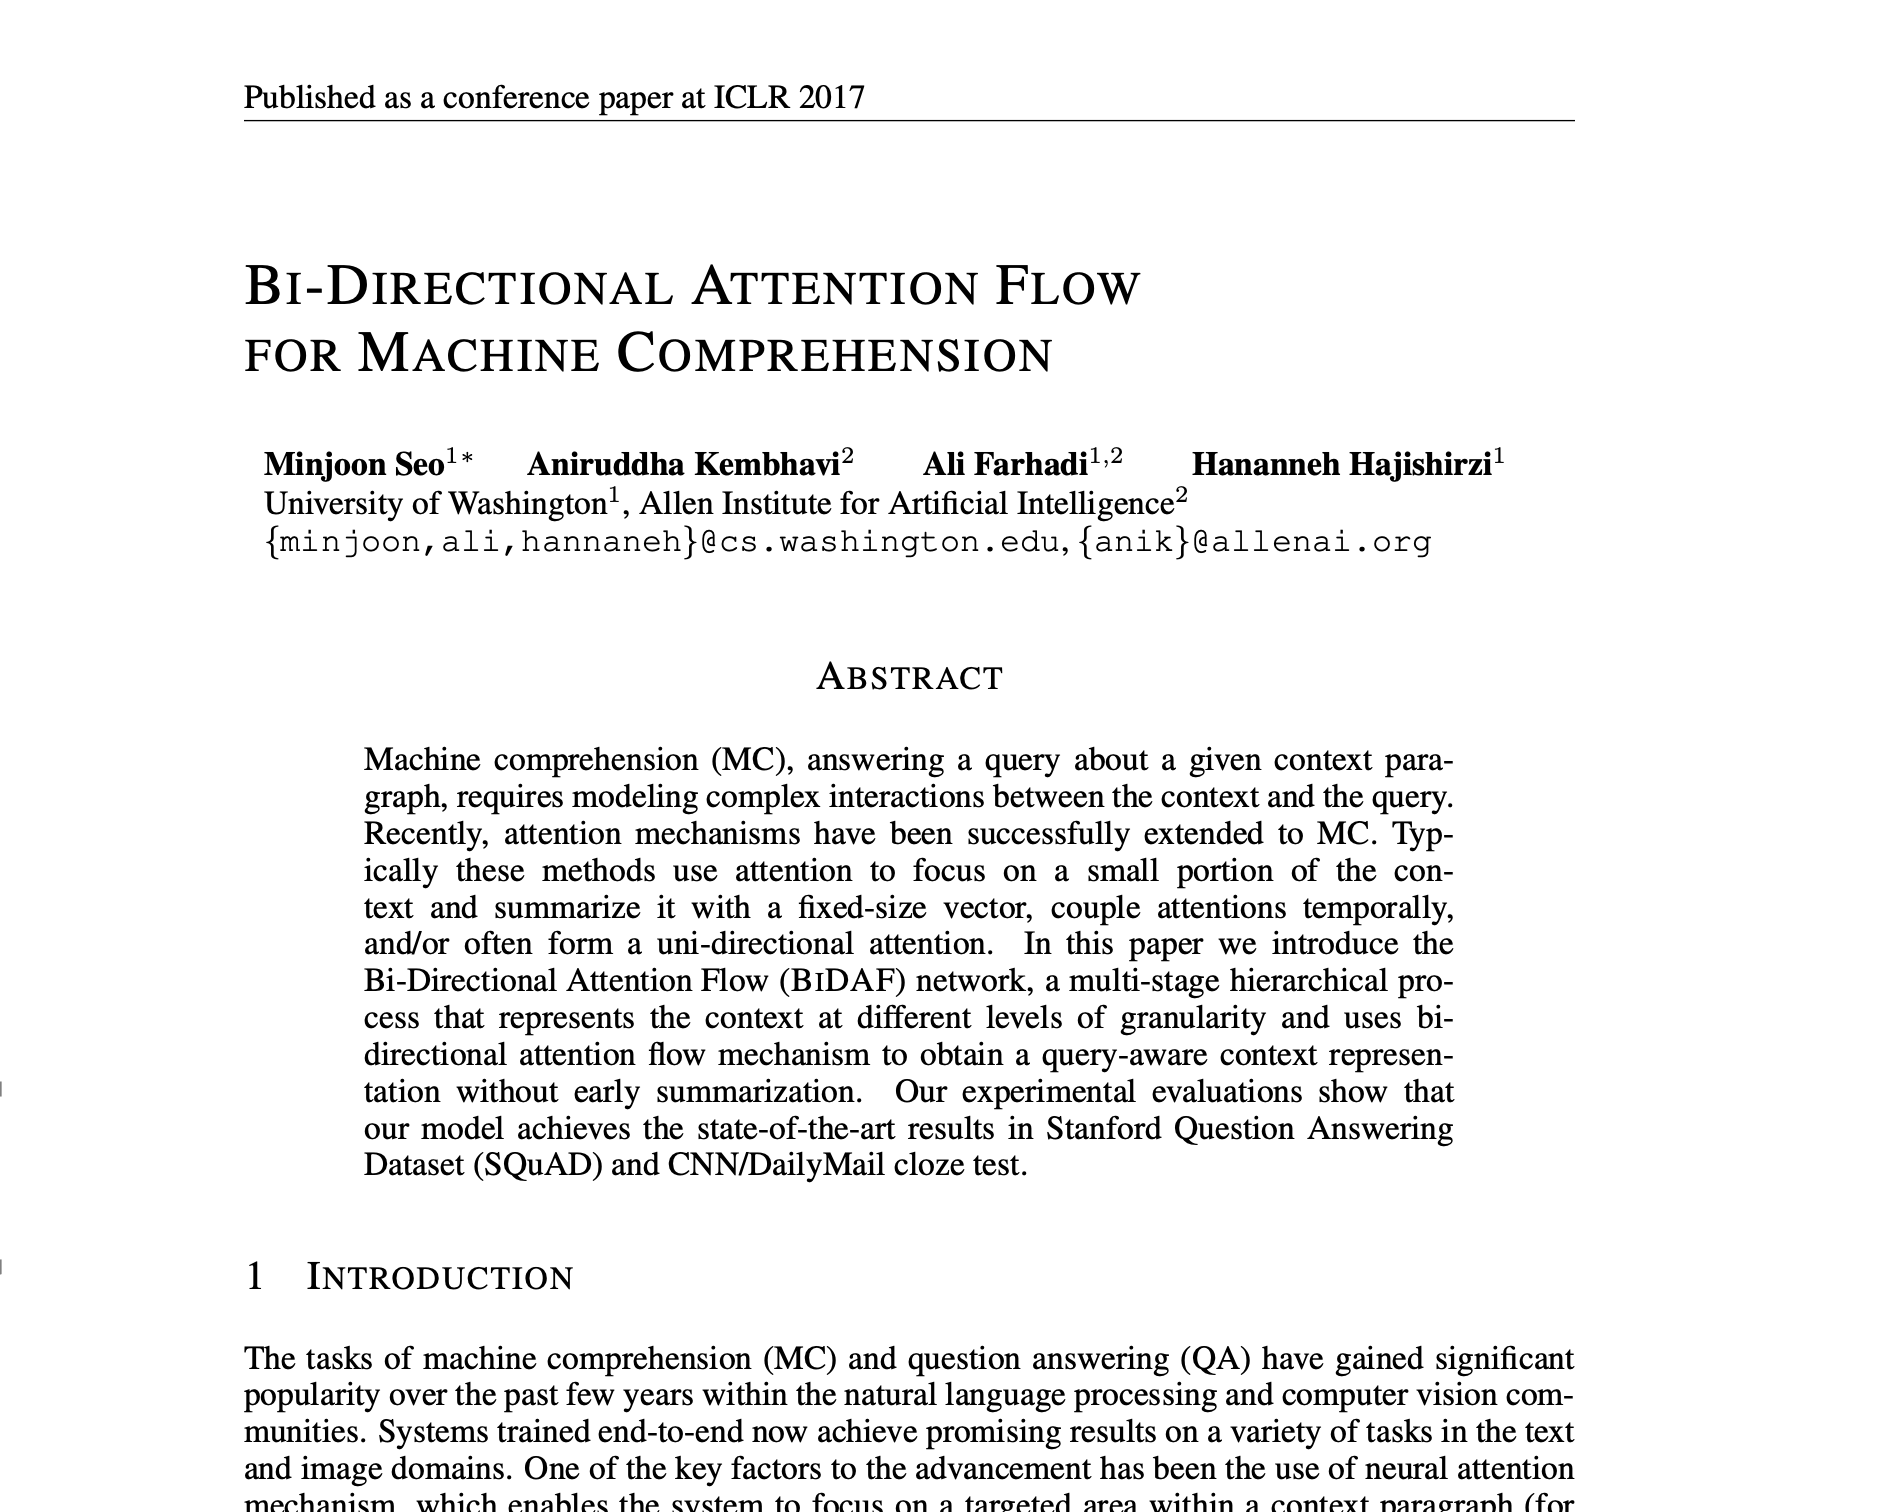

In [1]:
from IPython.display import Image 
Image(filename='paper.png')


Bi-Directional Attention Flow (Bi-DAF) network, a multi stage hierarchical process that represents the context at different levels of granularity and uses bi-directional attention flow mechanism to obtain a query aware representation without early summarization. 


How attention was used in previous approaches :- 

    a. The computed attention weights is used to extract most relevant information from the context by summarizing the context into a fixed size vector.
    b. Dynamic attention, attention weights at the current time step are a function of the attended vector at previous time step. 
    c. UniDirectional attention. 
    
    
What is different with attention here :- 

    a. Attention layer is not used to summarize the context graph vector. Instead attention is computed at every time step and, the attended vector at every time step, along with the representation from previous layer. 
    b. Memory less attention makes sure that, the attention at each time is a function of query and the context at current time step and does not directly depend on the previous time step 
    c. Division of work between attention layer and modelling layer 
    
        Attention Layer :- focuses on learning the attention between query and context 
        Modelling Layer :- Focus on learning the interaction within query aware context representation(o/p of attention layer)
    d. Bi-Directional Attention 
    
    

    


In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional  as F

## Model Architecture 

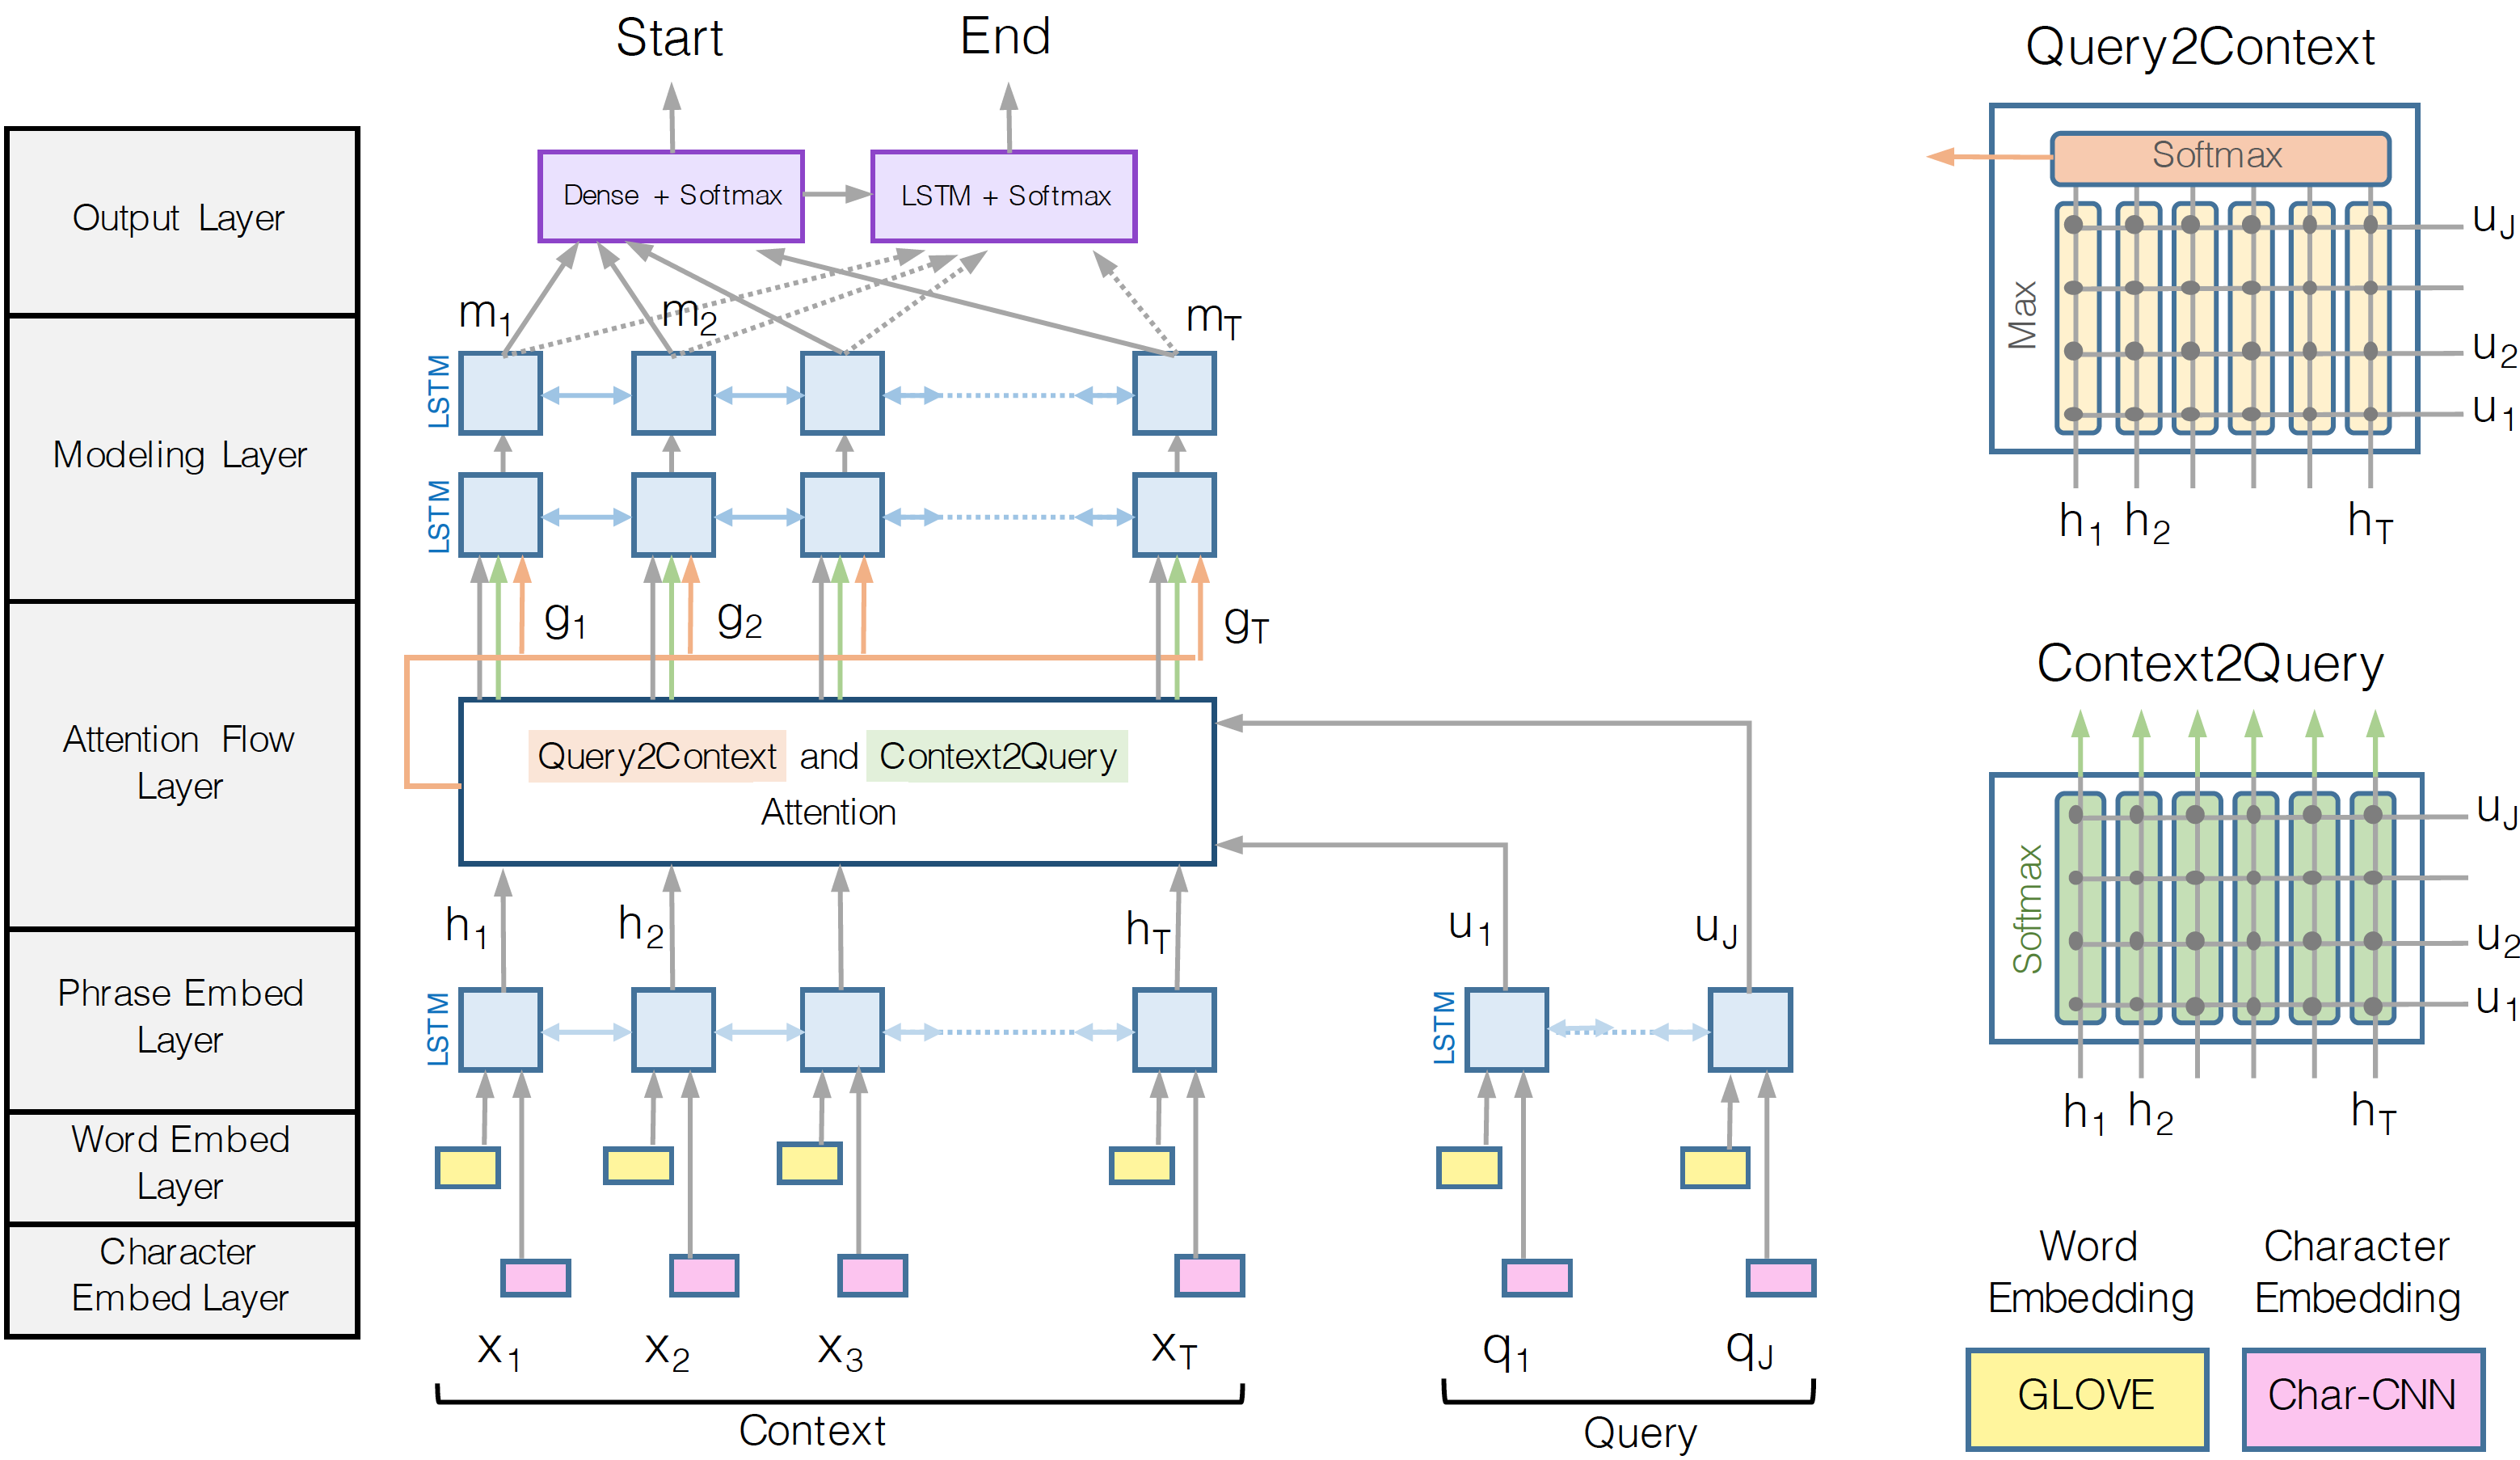

In [4]:
Image('BiDAF.png')

Model is a hierarchical multi-stage process and consists of six layers.

## Layer 1 :- Character Embedding Layer 

Maps each word to vector space using character level embedding <br>
ip = N, sen_len, word_len, vocab_size <br>
out = N, sen_len, channel_size<br>
    
    
Context :- {x <sub>1</sub> ,x <sub>2</sub> , ....., x <sub>T</sub> }<br>
Query :- {q <sub>1</sub> ,q <sub>2</sub> , ....., q <sub>J</sub> } <br>

T -> Context and J -> Query <br>

<b> Sequence of operations </b> <br>
Context -> Embedding Layer -> Conv Layer -> Max Pool 


In [8]:
class CharEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size, kernel_size, out_channel):
        super().__init__(self)
        self.emb_size = emb_size 
        self.vocab_size = vocab_size 
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.conv = nn.Conv2d(1, out_channel, kernel_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        batch_size = x.size(0)
        # Shape :- (batch, seq_len, word_len, char_dim)
        x = self.dropout(self.emb(x))
        
        # Make x ready for convolution layer 
        # (batch * seq_len, char_dim, word_len)
        x = x.view(-1, emb_size, x.size(2)).unsqueeze(1)
        
        # (batch * seq_len, char_channel_size, 1, conv_len) 
        x  = self.conv(x)
        # (batch, seq_len, conv_len)
        x = x.squeeze()
        
        # (batch * seq_len, char_channel_size, 1)
        x = F.max_pool1d(x, x.size(2)).squeeze()
        
        # (batch, seq_len, char_channel_size)
        x = x.view(batch_size, -1, self.out_channel)
        
        return x
        

### Layer 2 :- Word Embedding Layer and Highway Network 
    
In :- (N, Sentence_len) <br>
Out :- (N, sentence_len, embed_size) <br>
    
We can either make use of pretrained embeddings or train new embeddings.  Concat Character embedding and Word embedding and pass it to a highwar Network. 

<b> Highway Network </b> [link](https://arxiv.org/abs/1505.00387)

A plain Feed forward neural network and applies a non linear transformation. 
This network consists of mainly 2 layer, normal layer(Transform gate) and gate layer(Carry gate). <br> Difference is normal layer make use of <i>relu</i> and gate layer make use of <i>sigmoid</i>

In : Concat result(Context word and char embedding) X shape :-  (2d , T)

    Formula :- gate * normal_layer + (1 - gate) * x  



In [6]:
class WordEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, x):
        return self.embedding(x)
    
    
class Highway(nn.Module):
    def __init__(self, in_size, n_layers=2):
        super().__init__()
        self.n_layers = n_layers
        
        self.normal_layer = nn.ModuleList([nn.Linear(in_size, in_size) for _ in range(n_layers)])
        self.gate_layer = nn.ModuleList([nn.Linear(in_size, in_size) for _ in range(n_layers)])
        
        
    def forward(self, x):
        for i in range(self.n_layers):
            normal_layer_ret = F.relu(self.normal_layer[i](x))
            gate = F.sigmoid(self.gate_layer[i](x))
            
            x = gate * normal_layer_ret + (1 - gate) * x  
            
        return x 
    

### Layer 3 :- Contextual Embedding Layer 

LSTM is used on top of word embeddings which we got from previos layers to model temporal interactions between words to model temporal interactions b/w words. Bi-Directional LSTM and output is concatenated. 

Input H = 2d * T (d is dimension, T length of Context)
U = 2d * J ( d is dimension, J length of query)

In the first three layers, we are computing features from the query and context. Similar to the concept of convulational neural network in CV. 

In [9]:
hidden_size = 100
context_embedding_layer = nn.LSTM(input_size = hidden_size * 2, 
                                 hidden_size = hidden_size, 
                                 bidirectional = True, 
                                 batch_first = True, 
                                 dropout = 0.2)

/Users/rajat/Documents/env/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Layer 4 :- Attentional Flow Layer 

It is responsible for linking and fusing information from the context and query words. Doesn't summarize instead attention vector is allowed to pass through to modelling layer. 

Inputs :- Comtextual vector representation of the context H and query U.
Output :- Query aware representation of context words, G along with contextual embedding from the previous layer. 

We compute bidirectional attention, first form context to query and from query to context. To derive this we use Similarity matrix, which is computer by 

<pre>                     S = a(H<sub>:t</sub>, U<sub>:j</sub>) </pre>
here a is trainable scalable function that encodes the similarity between two input vector H<sub>:t</sub> and U<sub>:t</sub> is t-th column vector of H and U<sub>:j</sub>, j-th column vector of U. 

<pre>                     a(h, u) = w<sup>T</sup><sub>(s)</sub>\[h; u; h o u]</pre>

In [12]:
# context_emb => result of eontext embedding  (N, T, 2d)
# query_emb => result of query embedding      (N, J, 2d)

In [13]:
# shape = (N, T, J, 2d)
shape = (batch, T, J, 2 * d)
context_emb_ex = context_emb.unsqueeze(2) #(N, T, 1, 2d)
context_emb_ex = context_emb_ex.expand(shape) #(N, T, J, 2d)

query_emb_ex = query_emb.unsqueeze(1) # (N, 1, J, 2d)
query_emb_ex = query_emb_ex.expand(shape) #(N, T, J, 2)d

a_elmwise_mul_b = torch.mul(embd_context_ex, embd_query_ex) # (N, T, J, 2d)
concat_data = torch.cat((context_emb_ex, query_emb_ex, a_elmwise_mul_b), 3)

similarity_layer = nn.Linear(6 * d, 1)
S = similarity_layer(cat_data)

S = S.view(batch_size, T. J) # (N, T, J)

NameError: name 'batch' is not defined

Similarity Matrix :- Computed once and used to compute both direction of attention. S in not the attention itself it is an an unnormalized 2D similarity between the content and query words 

#### Context 2 query

Shows which query words most relevant to each context word. 

Attention weight is computed by 

<pre>                    a<sub>t</sub> = softmax(S<sub>t:</sub>)</pre>
<pre>                    w(S), shape = (6d) </pre> 



In [14]:
# Context 2 query 

torch.bmm(F.softmax(S, dim=1), query_emb) 

# N, T, 2d = bmm((N, 1, T), (N, T, 2d))




NameError: name 'S' is not defined

In [ ]:
#Query 2 Context 

beta = F.softmax(torch.max(S, dim=1), query_emb) # (N, T)

q2c = torch.bmm(beta.unsqueeze(1), context_emb) # (N, 1, 2d) = bmm((N, 1, T), (N, T, 2d))

q2c = q2c.repeat(1, T, 1) # (N, T, 2d)  tiles T times


### Layer 5 :- Modelling Layer 

    i/p:-  Query aware representation of context words 
    o/p :- interaction among the contextual words conditioned on the query. 

In [9]:


modelling_lstm = nn.LSTM(input_size=hidden_size * 8, 
                        hidden_size = hidden_size, 
                        bidirectional = True, 
                        batch_first = True, 
                        dropout = dropout)

### Layer 6 :- Output Layer 

In [10]:
# We can Modify output layer according to requirements
# TODO